In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt
import time

数据的形状：$$x=\left( \begin{array}{c}{x_{0}} \\ {x_{1}} \\ {\vdots} \\ {x_{m}}\end{array}\right)$$

拼接完成后数据的形状：$$X=\left( \begin{array}{ccc}{x_{0}} & {x_{0}^{2}} & \cdots & {x_{0}^{n}} \\ {x_{1}} & {x_{1}^{2}} & \cdots & {x_{1}^{n}} \\ {\vdots} & {\vdots} & {\ddots} & {\vdots}\\ {x_{m}} & {x_{m}^{2}} &\cdots & {x_{m}^{n}}\end{array}\right)$$

torch.Size([3000])


tensor([[  1.0000],
        [  1.0330],
        [  1.0660],
        ...,
        [ 99.9340],
        [ 99.9670],
        [100.0000]])

torch.Size([3000, 1])


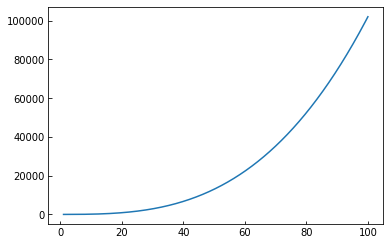

In [3]:
m = 3000 # m:数据个数,i.e. batch size   

BATCH_SIZE = 100 # 每一批有多少个数据
x = torch.linspace(1,100,m)
print(x.shape)
x.unsqueeze_(1)
print(x.shape)
randomdata = torch.randn(m,1)*0.01
##############################################################
y = 10+ 0.5*x + 0.2*x**2 + 0.1* x**3 #+ randomdata
n = 4 #n：多项式系数个数
##############################################################
plt.plot(np.array(x),np.array(y))

def make_features(x,n):
#     x.unsqueeze_(0)# 所谓解压缩，就是阔维，添加将现有的数据放入到指定的新维度上去
    print(x.shape) 

    # 这里我们以m所在的维度进行拼接：
    X= torch.cat([x**i for i in range(1,n)],1) # 实现tensor的拼接
    print(X.shape)
    return X

Feature engineering!!! 这必不可少，尤其是针对梯度下降算法  
Normalization 

由公式
  $$ \theta_0 x_0^{(i)}+ \theta_1 x_1^{(i)} + ... +\theta_n x_n^{(i)} = y^{(i)}\\\\
\Rightarrow \theta_0 + \theta_1 x_1^{(i)} + ... +\theta_n x_n^{(i)} = y^{(i)} \\\\
\Rightarrow\theta_0 + \theta_1( x_{1min}^{(i)}+ x_1^{(i)}-x_{1min}^{(i)})+ ... +\theta_n( x_{nmin}^{(i)}+ x_n^{(i)}-x_{nmin}^{(i)})
= y^{(i)}\\\\
\Rightarrow\theta_0 +\theta_1( x_{1min}^{(i)}) + ... + \theta_n( x_{nmin}^{(i)})+
\theta_1 S_1 \frac{( x_1^{(i)}-x_{1min}^{(i)})}{S_1}+ ... +\theta_n S_n \frac{( x_n^{(i)}-x_{nmin}^{(i)})}{S_n} = 
y^{(i)}\\\\
\left(
  \begin{matrix}
    Original    &  Normalized\\
   \theta_0 &  \theta_0 +\theta_1( x_{1min}^{(i)}) + ... + \theta_n( x_{nmin}^{(i)})\\
   \theta_j &  \theta_j S_j\\
       x_j&  \frac{( x_j^{(i)}-x_{jmin}^{(i)})}{S_j}
   \end{matrix} 
  \right)\\\\
where \qquad
S_j = {Multiple}  \\
\qquad  x_{jmin} \Leftrightarrow x_{jmean}, Multiple\Leftrightarrow \sigma
$$


In [4]:
X = make_features(x,n)

print(X[300,:])
print(X.std(0))
print(X.mean(0))
X_Normalized=torch.zeros(X.size())
for _ in range(X.size(0)):
    X_Normalized[_,:]=(X[_,:]-X.mean(0))/X.std(0) # 由公式11可知，这样变换之后，得到的权重theta 相应可以通过 theta_j/S_j
                                        # theta_0 = theta_0 + sum(theta[i] * x_mean(i)) 变换回来

print(X_Normalized[2900,:])

torch.Size([3000, 1])
torch.Size([3000, 3])
tensor([  10.9033,  118.8820, 1296.2061])
tensor([2.8593e+01, 2.9790e+03, 2.8396e+05])
tensor([5.0500e+01, 3.3675e+03, 2.5261e+05])
tensor([1.6169, 2.0106, 2.2979])


In [6]:
print(X_Normalized.shape,y.shape)
dataset = Data.TensorDataset(X_Normalized,y)
# 定义需要加载进去的模式
loader = Data.DataLoader(dataset= dataset, batch_size= BATCH_SIZE, shuffle = True)

torch.Size([3000, 3]) torch.Size([3000, 1])


In [36]:
iter(loader)
# bx,by=next(iter(loader))
# (bx,by)
# 每次调用loader时都将会产生不同的batch_x与batch_y
# for step,(batch_x,batch_y) in enumerate(loader):    
#     print(step,batch_x.shape,batch_y.shape,batch_x[1,:])

In [54]:

w = torch.ones(n-1,1, requires_grad=True) # w的行应该等于X的列，这样才能保证矩阵相乘
b = torch.ones(1,1, requires_grad=True)
data_x = loader.dataset.tensors[0]
data_y = loader.dataset.tensors[1]
def y_pred(x):
    '''predict function'''
    return x.mm(w)+b

print(y_pred(data_x)[:10,0])       

tensor([-2.7508, -2.7497, -2.7485, -2.7473, -2.7461, -2.7450, -2.7438, -2.7426,
        -2.7414, -2.7402], grad_fn=<SelectBackward>)


关于pytorch梯度累加  
https://www.zhihu.com/question/303070254  
但它上面提的计算方式的效率似乎没有下面我这个好！

In [97]:
learning_rate = 1e-4
time0= time.time()
for t in range(50):
    
#     (b_x,b_y)=next(iter(loader))
    for (b_x,b_y) in loader:
        # forword prop
        y_pred = b_x.mm(w)+ b

        # loss function
        loss = (y_pred - b_y).pow(2).sum()

        # 利用autograd去计算loss函数的反向传播中所有梯度
        loss.backward()

        # 更新权重
        # 这里选择利用梯度下降手动更新权重，当然也可以使用torch.optim.SGD进行梯度下降
        with torch.no_grad():
            w -= learning_rate * w.grad #因为前面的.backward,所以这里w1.grad直接获取到w1的梯度
            b -= learning_rate * b.grad

    w.grad.zero_()# 手动将梯度归零,否则梯度会累积
    b.grad.zero_()

    if t % 10 == 0:
        print(t, loss.item())

        
# 应用公式11 变换回来
W = w/(X.std(0).unsqueeze(1))
print(W)
B = b-W.t().mm(X.mean(0).unsqueeze(1))
print(B)
print('time pass{} s'.format(time.time()-time0))

0 0.07349200546741486
10 0.057223930954933167
20 0.06393042951822281
30 0.0629267692565918
40 0.057625286281108856
tensor([[0.4916],
        [0.2002],
        [0.1000]], grad_fn=<DivBackward0>)
tensor([[10.0762]], grad_fn=<SubBackward0>)
time pass1.4736008644104004 s


对比下面的方式，这里发现一个比较奇怪的现象，上面使用DataLoader进行对数据批处理似乎非常耗时，不知是不是这个模块对并行运算比较快。  
注意： 虽然上面用批处理的loss的值比下面的要小，这不意味着它的精度要更高，只是因为  
它是一个批次的MSE


In [57]:
w = torch.randn(n-1,1, requires_grad=True)
b = torch.randn(1,1, requires_grad=True)
data_x = loader.dataset.tensors[0]
data_y = loader.dataset.tensors[1]

In [88]:
learning_rate = 1e-4
time0 = time.time()
for t in range(801):    
    # forword prop
    y_pred = data_x.mm(w)+b

    # loss function
    loss = (y_pred - data_y).pow(2).sum()
    
    # 利用autograd去计算loss函数的反向传播中所有梯度
    loss.backward()

    # 更新权重
    # 这里选择利用梯度下降手动更新权重，当然也可以使用torch.optim.SGD进行梯度下降
    with torch.no_grad():
        w -= learning_rate * w.grad #因为前面的.backward,所以这里w1.grad直接获取到w1的梯度
        b -= learning_rate * b.grad
        w.grad.zero_()
        b.grad.zero_()
    if t % 100 == 0:
        print(t, loss.item())

        
# 应用公式11 变换回来
W = w/(X.std(0).unsqueeze(1))
B = b-W.t().mm(X.mean(0).unsqueeze(1))

print_poly = '{:.3f}+ '.format(B[0].item())+' + '.join(['{:.3f} x^{}'.format(W[i].item(),i+1) for i in range(len(W))])
print('多项式为: {}'.format(print_poly))
print('time pass{} s'.format(time.time()-time0))

0 1.867429494857788
100 1.867429494857788
200 1.867429494857788
300 1.867429494857788
400 1.867429494857788
500 1.867429494857788
600 1.867429494857788
700 1.867429494857788
800 1.867429494857788
多项式为: 10.076+ 0.492 x^1 + 0.200 x^2 + 0.100 x^3
time pass0.271728515625 s


### 使用pytorch的模块

In [122]:
# 定义模型
class Net(nn.Module):
    def __init__(self,n):
        super(Net,self).__init__()
        self.predict = nn.Linear(n-1,1)
        
    def forward(self,x):
        out = self.predict(x)
        return out

poly = Net(n)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(poly.parameters(),lr=1e-3)
print(poly)


Net(
  (predict): Linear(in_features=3, out_features=1, bias=True)
)


1567423360.0


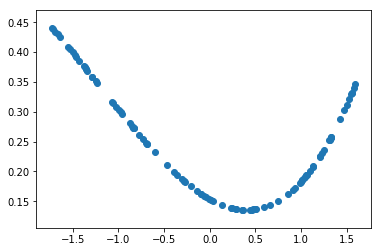

1673180544.0


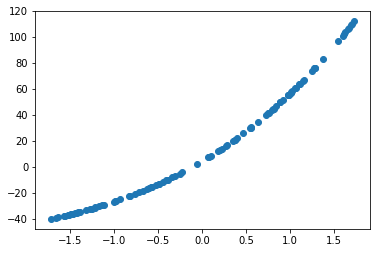

torch.Size([3, 1]) torch.Size([1, 1])
多项式为: -81.387+ 1.028 x^1 + 0.010 x^2 + 0.000 x^3


In [123]:
epochs = 1000
while epochs:
    
    for step,(batch_x,batch_y) in enumerate(loader):
        pred_y = poly(batch_x)
        loss = criterion(pred_y,batch_y)
        
        print_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epochs % 500 ==0:
        plt.scatter(batch_x[:,0].data.numpy(),pred_y[:,0].data.numpy())
        print(loss.item())
        plt.pause(0.2)
        plt.close()

    epochs -= 1
    if print_loss < 1e-2:
        break

   
count =0 
for i in poly.parameters():
    if count ==0:
        w = i.data
        count += 1
    else:
        b = i.data


w=w.view(n-1,1)
b=b.view(1,1)
print(w.shape,b.shape)
# 应用公式11 变换回来
W = w/(X.std(0).unsqueeze(1))
B = b-W.t().mm(X.mean(0).unsqueeze(1))

print_poly = '{:.3f}+ '.format(B[0].item())+' + '.join(['{:.3f} x^{}'.format(W[i].item(),i+1) for i in range(len(W))])
print('多项式为: {}'.format(print_poly))

tensor([[1.2932e+02, 1.4058e+02, 1.4364e+02],
        [1.2413e+00, 1.3493e+00, 1.3786e+00],
        [1.3022e-02, 1.4155e-02, 1.4463e-02]])